In [26]:
import numpy as np
from astropy.io import fits
from dust_extinction.parameter_averages import F99
from astropy import units as u
from astropy import coordinates as coords
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from spectres import spectres
import math #for log10
import statistics #for mean() function
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust
from dust_extinction.parameter_averages import CCM89 # Importamos el modelo de Cardelli, Clayton & Mathis (1989) con A_V = 1 y R_V = 3.1 
from scipy.optimize import curve_fit
import scipy.optimize as opt
from os import listdir
from os.path import isfile, join
from astropy.table import Table
from dust_extinction.parameter_averages import G03_SMCBar
%matplotlib inline

# Read observations

In [2]:
def get_obs(cenwave, exp1, exp2):
    exp = [exp1, exp2]
    for iexp in range(len(exp)): 
        data = fits.getdata(exp[iexp]) #We read the data.    
        seg = data[data['segment'] == 'FUVB'] #We extract the spectra from segment B.
        x1_tmp = seg['wavelength'][0]
        y1_tmp = seg['flux'][0]
        z1_tmp = seg['error'][0]    
        seg = data[data['segment'] == 'FUVA'] #We extract the spectra from segment A.
        x2_tmp = seg['wavelength'][0]
        y2_tmp = seg['flux'][0]
        z2_tmp = seg['error'][0]
    # Remove points where flux=0
        subx1, suby1, subz1 = np.transpose(np.array([pair for pair in zip(x1_tmp, y1_tmp, z1_tmp) if pair[1] > 0.]))
        subx2, suby2, subz2 = np.transpose(np.array([pair for pair in zip(x2_tmp, y2_tmp, z2_tmp) if pair[1] > 0.]))   
        if cenwave[iexp] == '1600':
    # We record the minimum wavelength for cenwave 1600 + 1623       
            xmin=min(subx1)
    # We record points spanning detector gap for cenwave 1600
            bmax1600=max(subx1)
            amin1600=min(subx2)
    # We record points at the right-most edge of the spectrum for cenwave 1600
            amax1600=max(subx2)
            x1600=np.append(subx1,subx2)
            y1600_tmp=np.append(suby1,suby2)
            z1600_tmp=np.append(subz1,subz2)
        else:
    # We record the maximum wavelength for cenwave 1600 + 1623
            xmax=max(subx2)
    # We record points spanning detector gap for cenwave 1623 
            bmax1623=max(subx1)
            amin1623=min(subx2)  
    # We record points at the right-most edge of the spectrum for cenwave 1623
            amax1623=max(subx2)
            x1623 = np.append(subx1,subx2)
            y1623_tmp=np.append(suby1,suby2)
            z1623_tmp=np.append(subz1,subz2)
    # We create a common wavelength array for cenwave 1600 + 1623 data
    newx=np.arange(xmin, xmax, 0.1)
    # We fill in corresponding flux array and set to zero wavelengths without fluxes at the given cenwave.
    # Setting to zero will be used in a next step.
    y1600 = spectres(newx, x1600, y1600_tmp, fill=0.)
    z1600 = spectres(newx, x1600, z1600_tmp, fill=0.)
    y1623 = spectres(newx, x1623, y1623_tmp, fill=0.)
    z1623 = spectres(newx, x1623, z1623_tmp, fill=0.)
    # Set to zero points within gaps and at the edge of the spectra.
    dx=4
    for ix in range(len(newx)):
        if (newx[ix] > bmax1600-dx) and (newx[ix] < amin1600+dx): #gap
            y1600[ix] = 0.
            z1600[ix] = 0.
        if abs(newx[ix] - amax1600) < 10.: #edge of spectrum
            y1600[ix] = 0.
            z1600[ix] = 0.
        if (newx[ix] > bmax1623-dx) and (newx[ix] < amin1623+dx): #gap
            y1623[ix] = 0.
            z1623[ix] = 0.
        if abs(newx[ix] - amax1623) < 10.: #edge of spectrum
            y1623[ix] = 0.
            z1623[ix] = 0.
    y=[]
    z=[]
    for ix in range(len(newx)):
        if y1600[ix] == 0. and y1623[ix] != 0.:
            y1600[ix] = y1623[ix]
            z1600[ix] = z1623[ix]
        if y1600[ix] != 0. and y1623[ix] == 0.:
            y1623[ix] = y1600[ix]
            z1623[ix] = y1600[ix]
        if ix == 0:
            y = y1600[ix]
            z = z1600[ix]
        else:
            y = np.append(y, (y1600[ix] + y1623[ix]) / 2)
            z = np.append(z, (z1600[ix]/y1600[ix] + z1623[ix]/y1623[ix]))
    return newx, y, z

# Read Models

In [3]:
def read_files(tipo, mi_path = '.'):
    """Lectura de archivos de un directorio dado, con una extensión dada
    Keywords:

    tipo [string] -- se le tiene que anteponer el punto; ej. '.txt', '.csv', etc.
    mi_path [string] -- directorio donde se encuentran nuestros archivos a leer. default('.')

    Return:

    files[list] -- lista de cadenas de texto con los nombres de los archivos de extensión "tipo"
    """
    files = [archivo for archivo in listdir(mi_path)]
    files = [f for f in files if ((not f.startswith('.'))&(not f.startswith('~'))&(f.endswith(tipo)))]
    print('Archivos leidos')
    return files

def read_table(path_file):
    table = Table.read(path_file, hdu=1)
    return table

def filter_ref(table, time):
    df = table.to_pandas()
    return df.filter(items=time)

# Get Milky Way E(B-V)

In [4]:
def get_ebvmw(galaxy = "NGC 3125"):
  #Have the `coords` module automatically look up the coordinates from the name of the source 
    pos = coords.SkyCoord.from_name(galaxy)
    table = IrsaDust.get_extinction_table(pos)

    A_B = table['A_SandF'][table['Filter_name'] == 'CTIO B'] # extinción Galáctica en la banda B
    A_V = table['A_SandF'][table['Filter_name'] == 'CTIO V'] # extinción Galáctica en la banda V
    ebvmw = A_B - A_V # exceso de color E(B-V) de la Vía Láctea (Milky Way)

  # Definimos el modelo de enrojecimiento debido al polvo
    mwext = F99(Rv=3.1)
    return ebvmw, mwext

# Get redshift correction

In [5]:
def get_z(target = "NGC 3125"):
    result_table = Ned.query_object(target)
    z = result_table['Redshift'][0]
    #print('z=',z)
    return z

def zcorr(x, target = "NGC 3125"):
    z = get_z(target)
    xrest = x / (1 + z) #Corrección por corrimiento al rojo de la galaxia que se está moviendo radialmente respecto al observador.
    return xrest, z

# Milky Way and Intrinsic Dereddening

In [6]:
def deredden(x, y, dy, ebv, ext):
    x_units = x * u.AA # longitud de onda
    y_units = y * u.Unit('erg cm-2 s-1 AA-1') # flujo
    dy_units = dy * u.Unit('erg cm-2 s-1 AA-1') # error en el flujo
    ydered_units = y_units / ext.extinguish(1/x_units.to(u.micron), Ebv=ebv)  #flujo corregido por extinción
    dydered_units = dy_units / ext.extinguish(1/x_units.to(u.micron), Ebv=ebv)
    ydered = ydered_units.value
    dydered = dy_units.value
    return ydered, dydered


def deredden_int(x, y, dy, ebv, ext = G03_SMCBar()):
    x_units = x * u.AA # longitud de onda
    y_units = y * u.Unit('erg cm-2 s-1 AA-1') # flujo
    dy_units = dy * u.Unit('erg cm-2 s-1 AA-1') # error en el flujo
    ydered_units = y_units / ext.extinguish(1/x_units.to(u.micron), Ebv=ebv)  #flujo corregido por extinción
    dydered_units = dy_units / ext.extinguish(1/x_units.to(u.micron), Ebv=ebv)
    ydered = ydered_units.value
    dydered = dy_units.value
    return ydered, dydered

# Find  beta

In [7]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_beta(x, y, xlo, xhi, dx = 2):
    good_indices = np.nonzero((abs(x-xlo) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y1=math.log10(statistics.mean(ygood))
    good_indices = np.nonzero((abs(x-xhi) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y2=math.log10(statistics.mean(ygood))
    x1 = math.log10(find_nearest(x, xlo))
    x2 = math.log10(find_nearest(x, xhi))
    beta=-(y1-y2)/(x1-x2)    
    return beta

def find_beta_model(x, y, xlo, xhi, dx = 2):
    good_indices = np.nonzero((abs(x-xlo) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y1=math.log10(statistics.mean(ygood))
    good_indices = np.nonzero((abs(x-xhi) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y2=math.log10(statistics.mean(ygood))
    x1 = math.log10(find_nearest(x, xlo))
    x2 = math.log10(find_nearest(x, xhi))
    beta=-(y1-y2)/(x1-x2) 
    y0=(10**y1)/((10**x1)**(-beta))
    ybeta = []
    for j in range(len(x)):
        ybeta.append(y0*x[j]**(-beta))
        f1500=y0*1500.**(-beta)
    return beta, ybeta, f1500

# Find observations Intrinsic E(B-V)

In [8]:
def find_ebvi(x, y, dy, beta, xlo, xhi, ext, dx = 2):
    ebvi=0.
    for iebv in range(190):#num. ebv pts, print((2-0.1)/0.01)=190
        if beta <= 2.59:
            ydered, dydered = deredden(x, y, dy, ebvi, ext)
            ebvi = ebvi + 0.01
            good_indices = np.nonzero((abs(x-xlo) <= dx))
            xgood1=x[good_indices]
            ygood1=ydered[good_indices]#np.array(ymerged)[good_indices]
            y1=math.log10(statistics.mean(ygood1))
            good_indices = np.nonzero((abs(x-xhi) <= dx))
            xgood2=x[good_indices]
            ygood2=ydered[good_indices]#np.array(ymerged)[good_indices]
            y2=math.log10(statistics.mean(ygood2))
            x1 = math.log10(find_nearest(x, xlo))
            x2 = math.log10(find_nearest(x, xhi))
            beta=-(y1-y2)/(x1-x2)
            y0=(10**y1)/((10**x1)**(-beta))
            #print(y0)
            #print(ebvi, beta)
        else:
            iebv == 190
            ybeta = []
            yrec = []
            for j in range(len(x)):
                ybeta.append(y0*x[j]**(-beta))
                yrec.append(ydered[j]/ybeta[j])
            f1500=y0*1500.**(-beta)
    return ebvi, ydered, dydered, ybeta, yrec, f1500, beta, xgood1, xgood2, ygood1, ygood2

# Scale factor and Chi square

In [9]:
def find_sf(x, y, f1500_obs, xlo, xhi, dx = 2):
    good_indices = np.nonzero((abs(x-xlo) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y1=math.log10(statistics.mean(ygood))
    good_indices = np.nonzero((abs(x-xhi) <= dx))
    xgood=x[good_indices]
    ygood=y[good_indices]#np.array(ymerged)[good_indices]
    y2=math.log10(statistics.mean(ygood))
    x1 = math.log10(find_nearest(x, xlo))
    x2 = math.log10(find_nearest(x, xhi))
    beta=-(y1-y2)/(x1-x2)
    y0=(10**y1)/((10**x1)**(-beta))
    f1500_mod=y0*1500.**(-beta)
    sf=f1500_mod/f1500_obs
    print(sf)
    y99sf = []
    for i in range(len(x)):
        y99sf=np.append(y99sf, y[i]/sf)
    return y99sf

def chisqfunc(obs, err, mod):
    chisq = np.sum(((obs - mod)/err)**2)
    return chisq

# Run code

In [10]:
#read Observations
cenwave = ['1600','1623']
exp1 = '../HST/others/le4gp2010_x1dsum.fits'
exp2 = '../HST/others/le4gp2020_x1dsum.fits'
wave, flux, errflux = get_obs(cenwave, exp1, exp2)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


In [11]:
#read Models
cols = ['Wavelength', 't1p00000E6', 't2p00000E6', 't3p00000E6', 't4p00000E6', 't5p00000E6', 't6p00000E6', 't7p00000E6', 't8p00000E6', 't9p00000E6', 't1p00000E7']
times = ['1e6', '2e6', '3e6', '4e6', '5e6', '6e6', '7e6', '8e6', '9e6', '1e7']

my_path = '../models/z006/'
files = read_files('hr_xmilesi_ssp.fits', mi_path = my_path)
#select file: ['cb2019_z006_chab_hr_xmilesi_ssp.fits', 'cb2019_z006_chab_MU300_hr_xmilesi_ssp.fits','cb2019_z006_chab_MU600_hr_xmilesi_ssp.fits']
file = my_path+files[0]
table = read_table(file)
df = filter_ref(table, cols)

Archivos leidos


In [12]:
xlo=1570
xhi=1700
ebvmw, mwext = get_ebvmw()
ydered, dydered = deredden(wave, flux, errflux, ebvmw, mwext)
xrest, z = zcorr(wave)
beta = find_beta(xrest, ydered, xlo, xhi)
good_indices = np.nonzero((np.array(df.Wavelength) > 1406.) & (np.array(df.Wavelength) <=1802.))
xmod = np.array(df.Wavelength)[good_indices]
ymod = np.array(df.t2p00000E6)[good_indices]
yobs = spectres(xmod, xrest, ydered, fill=0.)
dyobs = spectres(xmod, xrest, dydered, fill=0.)
ebvi, ydered, dydered, ybeta, yrec, f1500, beta, xgood1, xgood2, ygood1, ygood2 = find_ebvi(xmod, yobs, dyobs, beta, xlo, xhi, ext = G03_SMCBar())
print(ebvi, beta)
print(len(yobs))
print(len(ydered))

ysf = find_sf(xmod, ymod, f1500, xlo, xhi)
fit=np.nonzero((xmod>=1630.) & (xmod<=1650))
chi = chisqfunc(yobs[fit], dyobs[fit], ysf[fit])
print(chi)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

0.20000000000000004 2.6290752236031056
792
792
5516249124527.469
6.800381801940469e-26


# Plots

In [13]:
def find_plt_lim(x, y):
    good_indices = np.nonzero(x > 1406.)
    ymin = min(y[good_indices])
    good_indices = np.nonzero(x < 1802.)
    ymax = max(y[good_indices])
    return ymin, ymax 

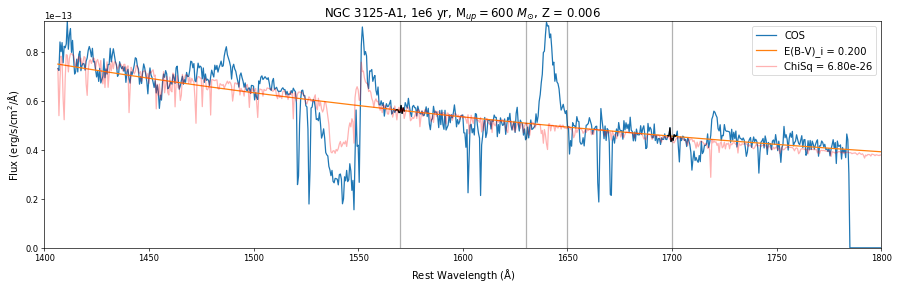

In [14]:
fig = plt.subplots(figsize=(18,5), dpi=60)
fontsize = 12
plt.title('NGC 3125-A1, '+times[0]+r" yr, M$_{up} = 600 \ M_{\odot}$, Z = 0.006", fontsize=fontsize+2)
plt.xlim(1400, 1800)
ymin, ymax = find_plt_lim(xmod, ydered)
plt.ylim(ymin, ymax)
plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=fontsize)
plt.ylabel(r'Flux ($\rm{erg/s/cm^2/\AA}$)', fontsize=fontsize)
plt.plot(xmod, ydered, label='COS')
txt='E(B-V)_i = {b:.3f}'
plt.plot(xmod, ybeta, label=txt.format(b=ebvi))
plt.plot(xgood1, ygood1, color='black')
plt.plot(xgood2, ygood2, color='black')
plt.axvline(x=xlo ,color="black",alpha=0.3,zorder=10)
plt.axvline(x=xhi ,color="black",alpha=0.3,zorder=10)
plt.axvline(x=1630. ,color="black",alpha=0.3,zorder=10)
plt.axvline(x=1650. ,color="black",alpha=0.3,zorder=10)
txt='ChiSq = {b:.2e}'
plt.plot(xmod, ysf, color='red', alpha=.3, label=txt.format(b=chi))
plt.legend(fontsize = fontsize)

# La siguiente celda realiza todo lo anterior tomando el modelo de MU = 100


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


Archivos leidos

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

4482621666446.408

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

5516249124527.469

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword 

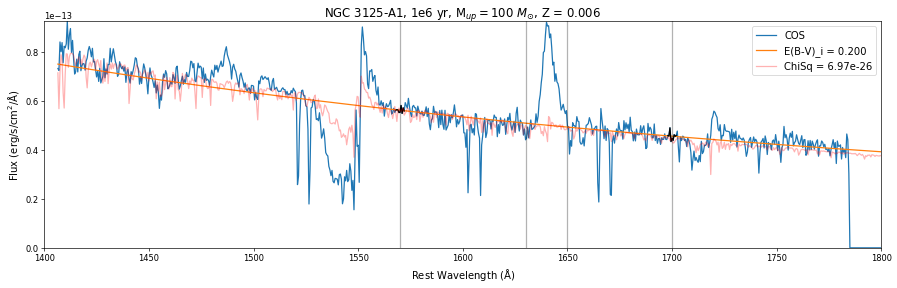

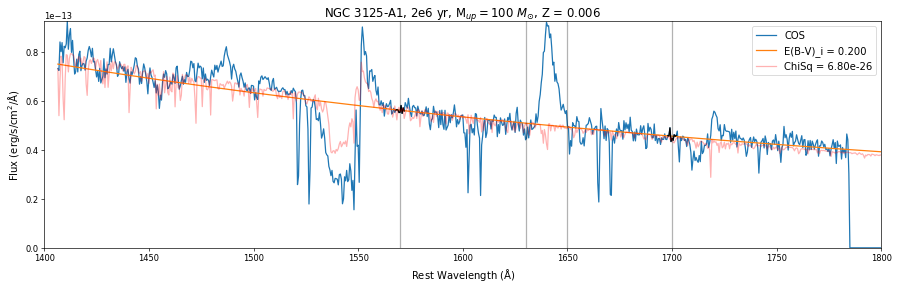

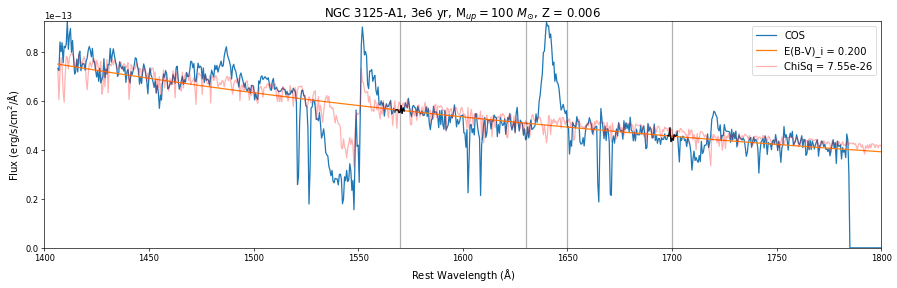

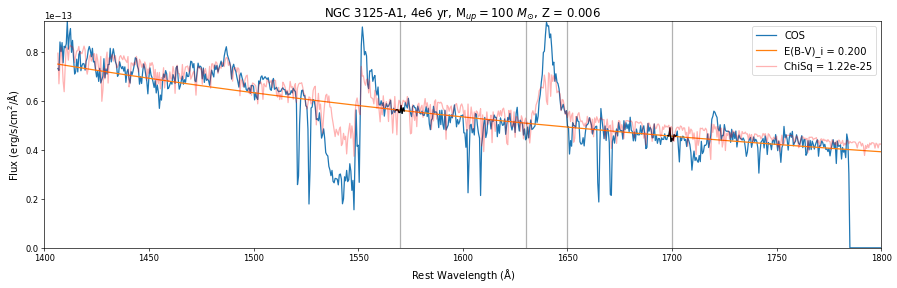

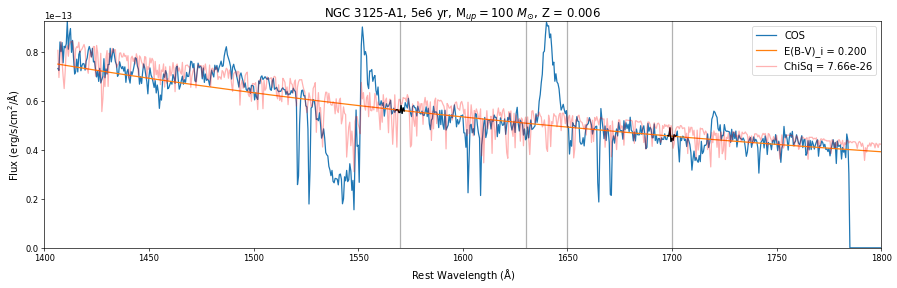

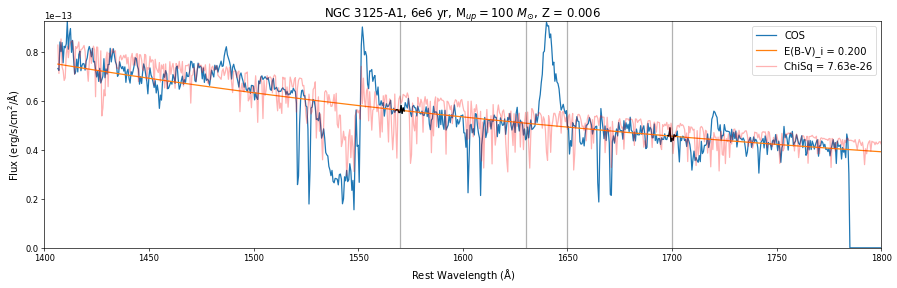

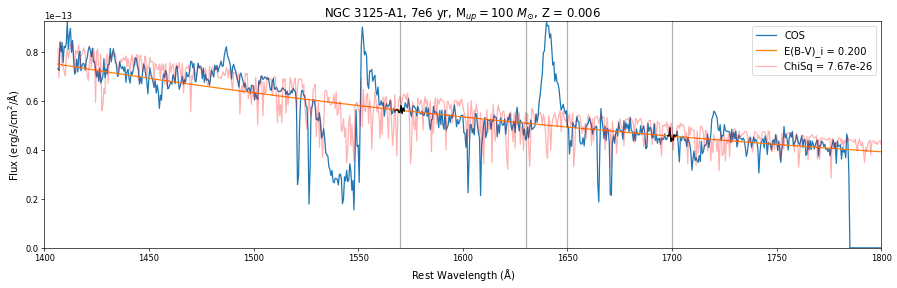

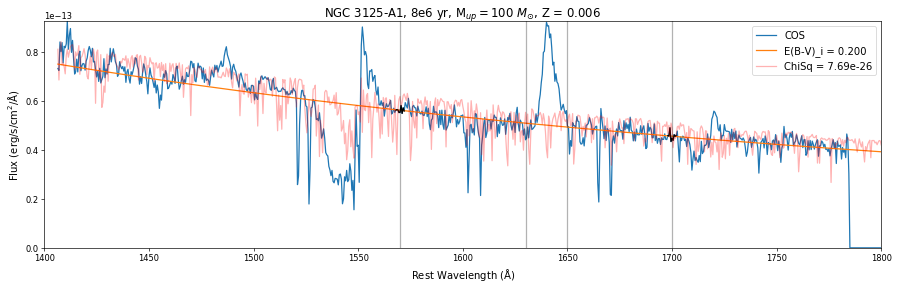

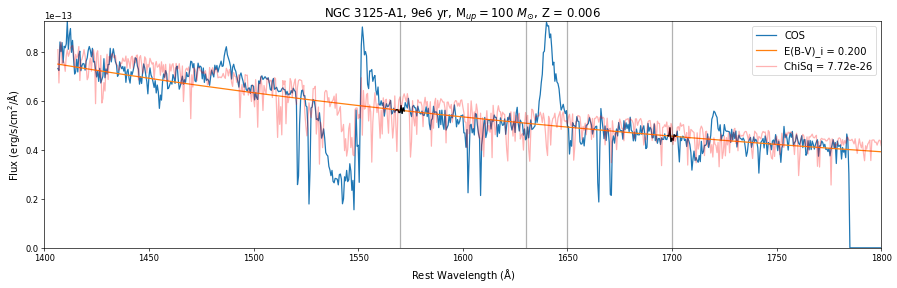

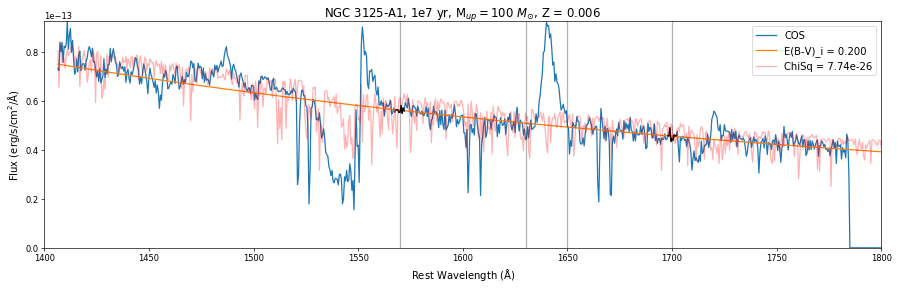

In [27]:
#read Observations
cenwave = ['1600','1623']
exp1 = '../HST/others/le4gp2010_x1dsum.fits'
exp2 = '../HST/others/le4gp2020_x1dsum.fits'
wave, flux, errflux = get_obs(cenwave, exp1, exp2)

#read Models
cols = ['Wavelength', 't1p00000E6', 't2p00000E6', 't3p00000E6', 't4p00000E6', 't5p00000E6', 't6p00000E6', 't7p00000E6', 't8p00000E6', 't9p00000E6', 't1p00000E7']
times = ['1e6', '2e6', '3e6', '4e6', '5e6', '6e6', '7e6', '8e6', '9e6', '1e7']
xlo=1570
xhi=1700
my_path = '../models/z006/'
files = read_files('hr_xmilesi_ssp.fits', mi_path = my_path)
#select file: ['cb2019_z006_chab_hr_xmilesi_ssp.fits', 'cb2019_z006_chab_MU300_hr_xmilesi_ssp.fits','cb2019_z006_chab_MU600_hr_xmilesi_ssp.fits']

ebvmw, mwext = get_ebvmw()
ydered, dydered = deredden(wave, flux, errflux, ebvmw, mwext)
xrest, z = zcorr(wave)
beta = find_beta(xrest, ydered, xlo, xhi)
chi_100 = {}
fontsize = 12

file = my_path+files[0]
ages = cols[1:]
for num in range(len(ages)):
    table = read_table(file)
    df = filter_ref(table, cols)
    good_indices = np.nonzero((np.array(df.Wavelength) > 1406.) & (np.array(df.Wavelength) <=1802.))
    xmod = np.array(df.Wavelength)[good_indices]
    ymod = np.array(df[ages[num]])[good_indices]
    yobs = spectres(xmod, xrest, ydered, fill=0.)
    dyobs = spectres(xmod, xrest, dydered, fill=0.)
    ebvi, ydered1, dydered1, ybeta, yrec, f1500, beta1, xgood1, xgood2, ygood1, ygood2 = find_ebvi(xmod, yobs, dyobs, beta, xlo, xhi, ext = G03_SMCBar())
    ysf = find_sf(xmod, ymod, f1500, xlo, xhi)
    fit=np.nonzero((xmod>=1630.) & (xmod<=1650))
    chi = chisqfunc(yobs[fit], dyobs[fit], ysf[fit])
    chi_100[ages[num]] = chi
    fig = plt.subplots(figsize=(18,5), dpi=60)
    plt.title('NGC 3125-A1, '+times[num]+r" yr, M$_{up} = 100 \ M_{\odot}$, Z = 0.006", fontsize=fontsize+2)
    plt.xlim(1400, 1800)
    ymin, ymax = find_plt_lim(xmod, ydered1)
    plt.ylim(ymin, ymax)
    plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=fontsize)
    plt.ylabel(r'Flux ($\rm{erg/s/cm^2/\AA}$)', fontsize=fontsize)
    plt.plot(xmod, ydered1, label='COS')
    txt='E(B-V)_i = {b:.3f}'
    plt.plot(xmod, ybeta, label=txt.format(b=ebvi))
    plt.plot(xgood1, ygood1, color='black')
    plt.plot(xgood2, ygood2, color='black')
    plt.axvline(x=xlo ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=xhi ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=1630. ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=1650. ,color="black",alpha=0.3,zorder=10)
    txt='ChiSq = {b:.2e}'
    plt.plot(xmod, ysf, color='red', alpha=.3, label=txt.format(b=chi))
    plt.legend(fontsize = fontsize)

print('El modelo con mejor chi2: ', max(chi_100, key=chi_100.get))

# La siguiente celda realiza todo lo anterior para el modelo de MU = 300


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


Archivos leidos

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

7610582325858.665

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

13352526659390.762

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword

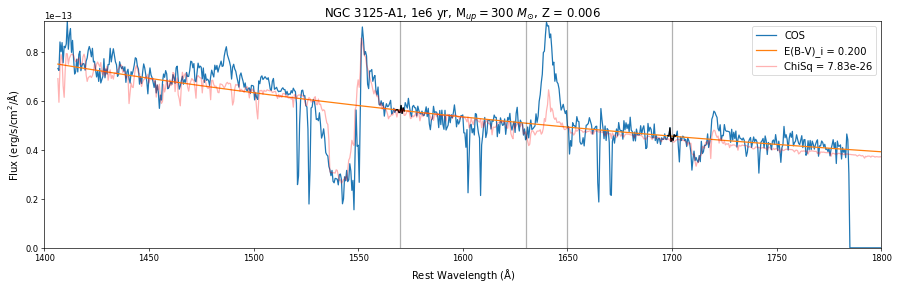

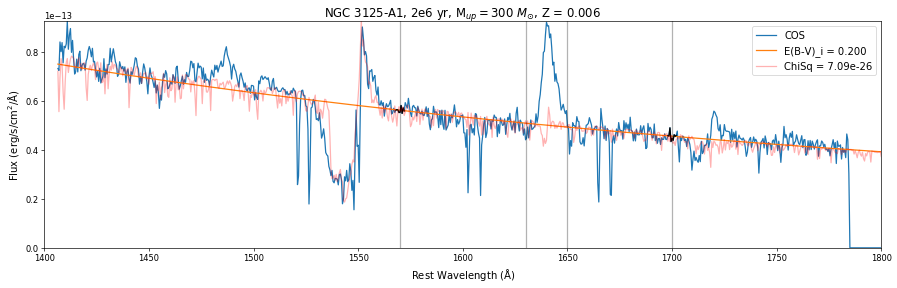

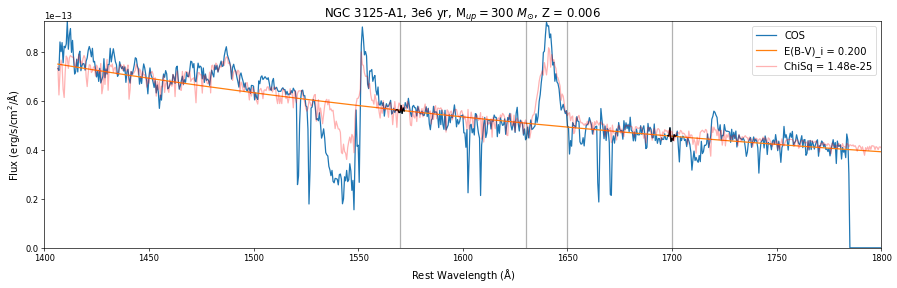

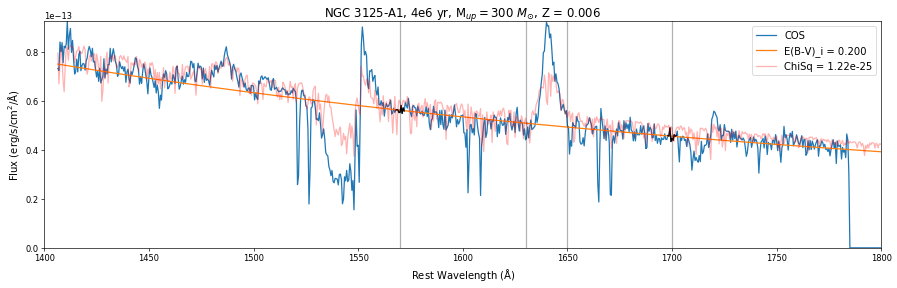

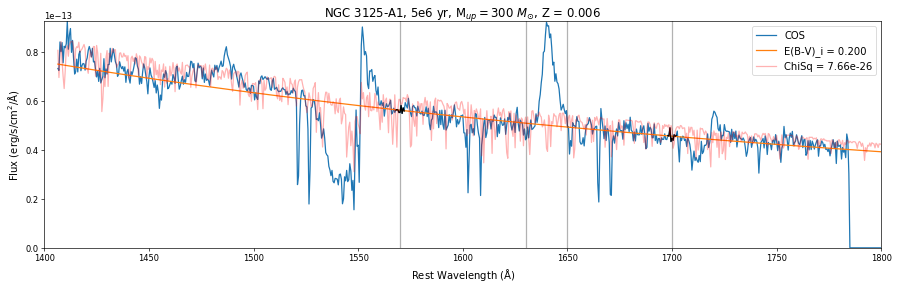

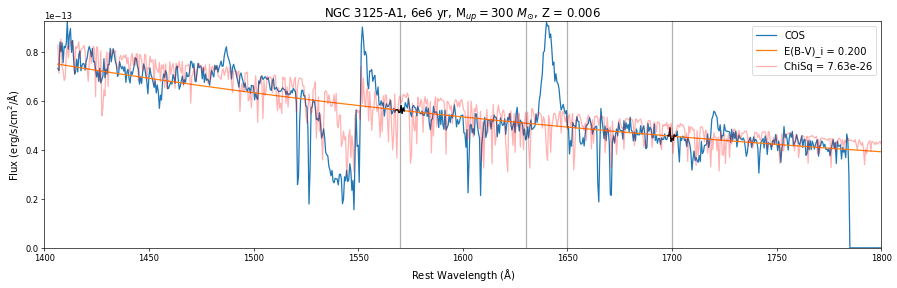

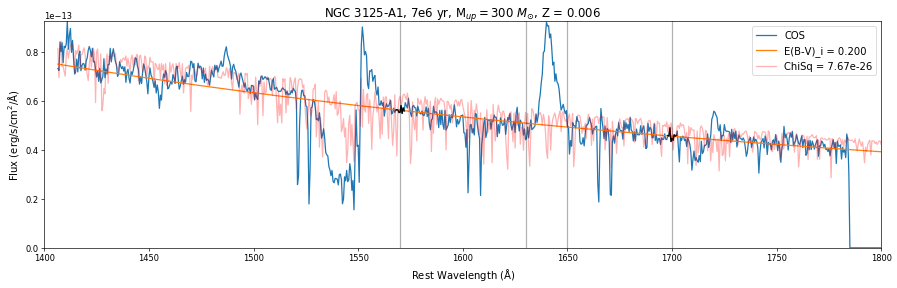

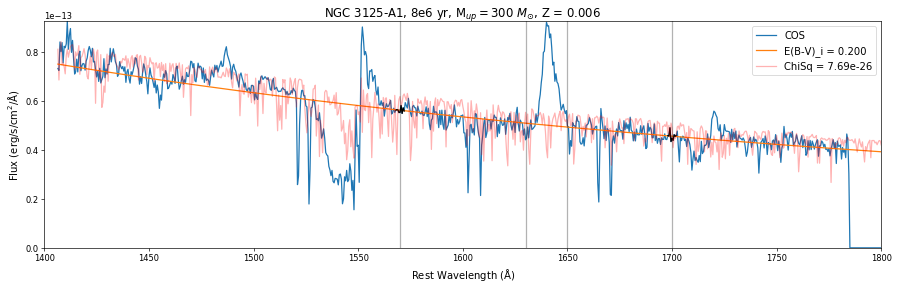

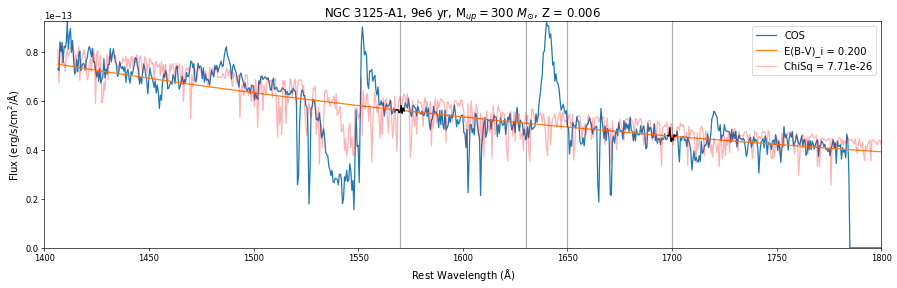

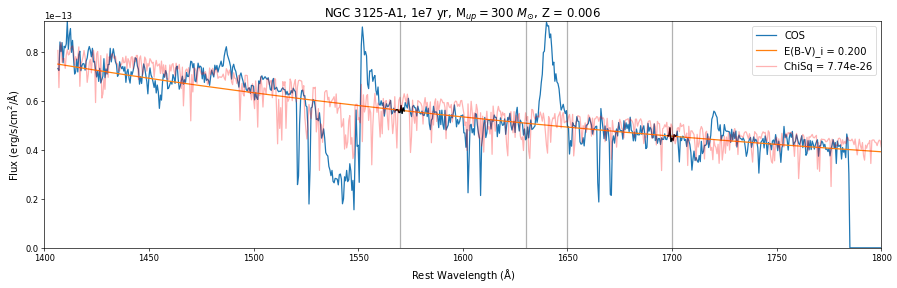

In [28]:
#read Observations
cenwave = ['1600','1623']
exp1 = '../HST/others/le4gp2010_x1dsum.fits'
exp2 = '../HST/others/le4gp2020_x1dsum.fits'
wave, flux, errflux = get_obs(cenwave, exp1, exp2)

#read Models
cols = ['Wavelength', 't1p00000E6', 't2p00000E6', 't3p00000E6', 't4p00000E6', 't5p00000E6', 't6p00000E6', 't7p00000E6', 't8p00000E6', 't9p00000E6', 't1p00000E7']
times = ['1e6', '2e6', '3e6', '4e6', '5e6', '6e6', '7e6', '8e6', '9e6', '1e7']
xlo=1570
xhi=1700
my_path = '../models/z006/'
files = read_files('hr_xmilesi_ssp.fits', mi_path = my_path)
#select file: ['cb2019_z006_chab_hr_xmilesi_ssp.fits', 'cb2019_z006_chab_MU300_hr_xmilesi_ssp.fits','cb2019_z006_chab_MU600_hr_xmilesi_ssp.fits']

ebvmw, mwext = get_ebvmw()
ydered, dydered = deredden(wave, flux, errflux, ebvmw, mwext)
xrest, z = zcorr(wave)
beta = find_beta(xrest, ydered, xlo, xhi)
chi_300 = {}
fontsize = 12

file = my_path+files[1]
ages = cols[1:]
for num in range(len(ages)):
    table = read_table(file)
    df = filter_ref(table, cols)
    good_indices = np.nonzero((np.array(df.Wavelength) > 1406.) & (np.array(df.Wavelength) <=1802.))
    xmod = np.array(df.Wavelength)[good_indices]
    ymod = np.array(df[ages[num]])[good_indices]
    yobs = spectres(xmod, xrest, ydered, fill=0.)
    dyobs = spectres(xmod, xrest, dydered, fill=0.)
    ebvi, ydered1, dydered1, ybeta, yrec, f1500, beta1, xgood1, xgood2, ygood1, ygood2 = find_ebvi(xmod, yobs, dyobs, beta, xlo, xhi, ext = G03_SMCBar())
    ysf = find_sf(xmod, ymod, f1500, xlo, xhi)
    fit=np.nonzero((xmod>=1630.) & (xmod<=1650))
    chi = chisqfunc(yobs[fit], dyobs[fit], ysf[fit])
    chi_300[ages[num]] = chi
    fig = plt.subplots(figsize=(18,5), dpi=60)
    plt.title('NGC 3125-A1, '+times[num]+r" yr, M$_{up} = 300 \ M_{\odot}$, Z = 0.006", fontsize=fontsize+2)
    plt.xlim(1400, 1800)
    ymin, ymax = find_plt_lim(xmod, ydered1)
    plt.ylim(ymin, ymax)
    plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=fontsize)
    plt.ylabel(r'Flux ($\rm{erg/s/cm^2/\AA}$)', fontsize=fontsize)
    plt.plot(xmod, ydered1, label='COS')
    txt='E(B-V)_i = {b:.3f}'
    plt.plot(xmod, ybeta, label=txt.format(b=ebvi))
    plt.plot(xgood1, ygood1, color='black')
    plt.plot(xgood2, ygood2, color='black')
    plt.axvline(x=xlo ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=xhi ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=1630. ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=1650. ,color="black",alpha=0.3,zorder=10)
    txt='ChiSq = {b:.2e}'
    plt.plot(xmod, ysf, color='red', alpha=.3, label=txt.format(b=chi))
    plt.legend(fontsize = fontsize)

print('El modelo con mejor chi2: ', max(chi_300, key=chi_300.get))

# La siguiente celda hace todo lo anterior para MU = 600


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


Archivos leidos

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

8957791761993.623

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

14733725355121.55

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword 

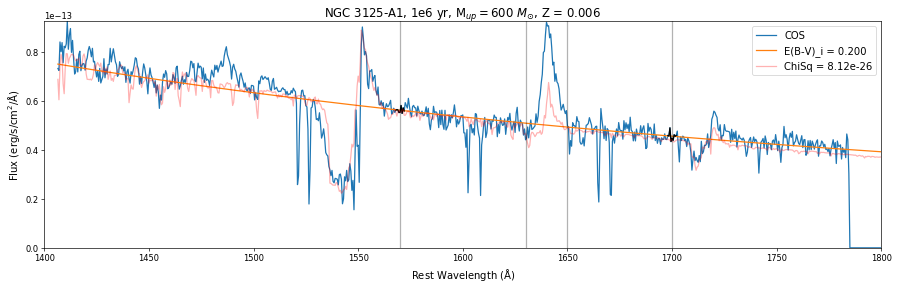

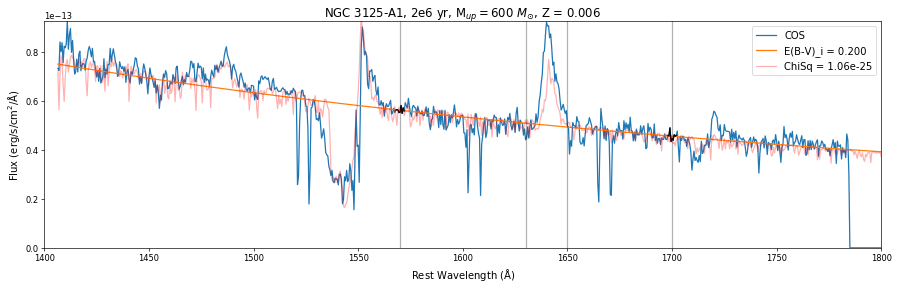

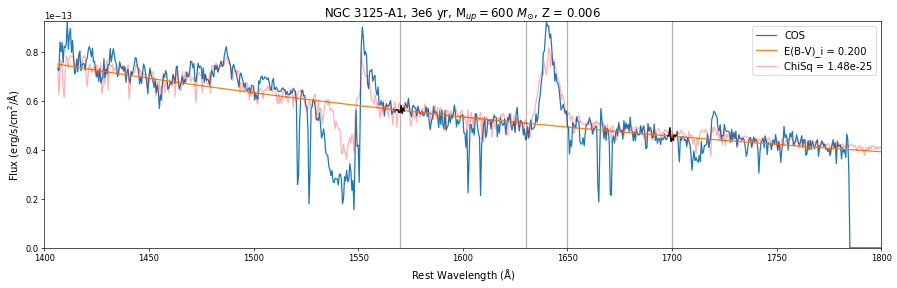

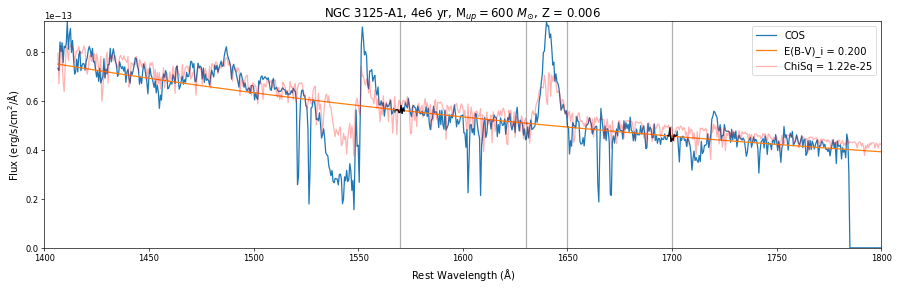

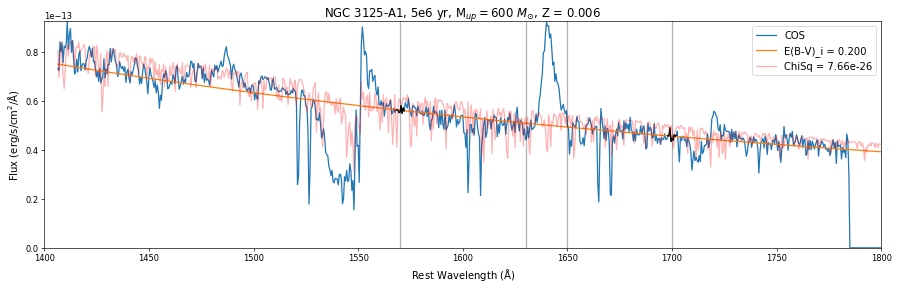

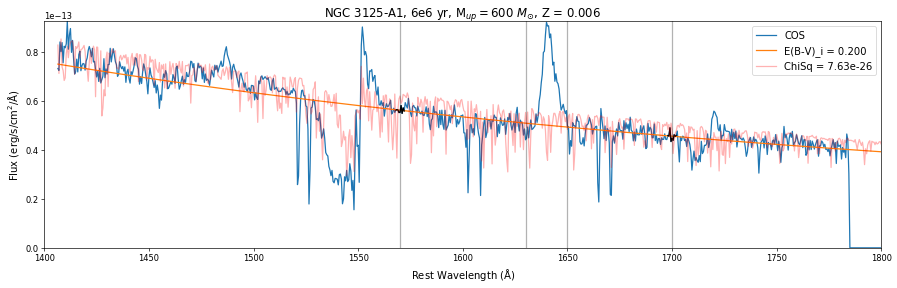

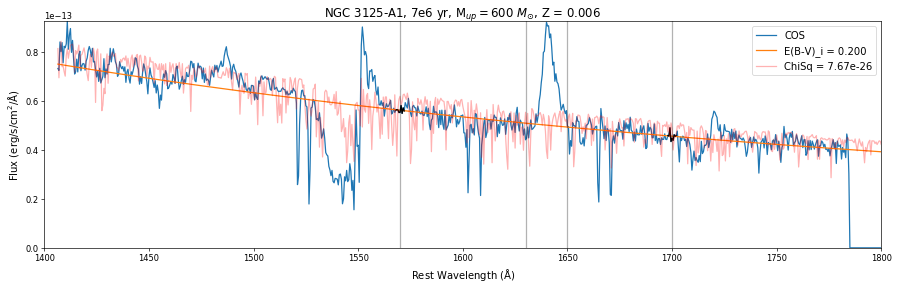

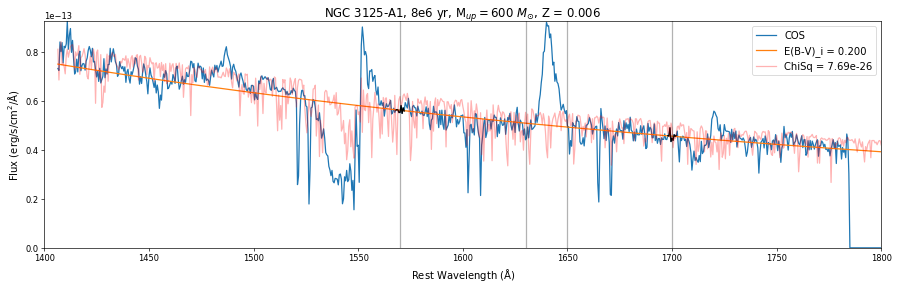

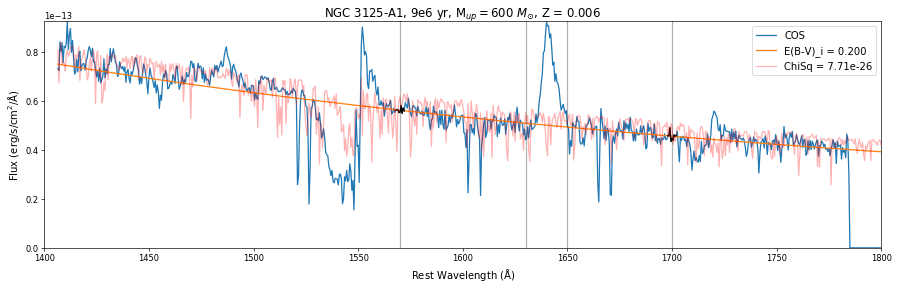

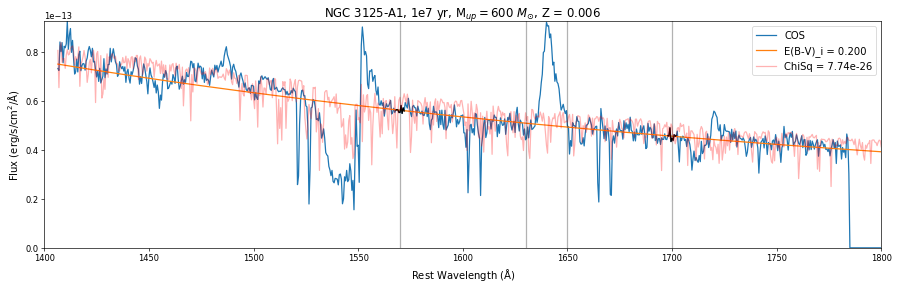

In [29]:
#read Observations
cenwave = ['1600','1623']
exp1 = '../HST/others/le4gp2010_x1dsum.fits'
exp2 = '../HST/others/le4gp2020_x1dsum.fits'
wave, flux, errflux = get_obs(cenwave, exp1, exp2)

#read Models
cols = ['Wavelength', 't1p00000E6', 't2p00000E6', 't3p00000E6', 't4p00000E6', 't5p00000E6', 't6p00000E6', 't7p00000E6', 't8p00000E6', 't9p00000E6', 't1p00000E7']
times = ['1e6', '2e6', '3e6', '4e6', '5e6', '6e6', '7e6', '8e6', '9e6', '1e7']
xlo=1570
xhi=1700
my_path = '../models/z006/'
files = read_files('hr_xmilesi_ssp.fits', mi_path = my_path)
#select file: ['cb2019_z006_chab_hr_xmilesi_ssp.fits', 'cb2019_z006_chab_MU300_hr_xmilesi_ssp.fits','cb2019_z006_chab_MU600_hr_xmilesi_ssp.fits']

ebvmw, mwext = get_ebvmw()
ydered, dydered = deredden(wave, flux, errflux, ebvmw, mwext)
xrest, z = zcorr(wave)
beta = find_beta(xrest, ydered, xlo, xhi)
chi_600 = {}
fontsize = 12

file = my_path+files[2]
ages = cols[1:]
for num in range(len(ages)):
    table = read_table(file)
    df = filter_ref(table, cols)
    good_indices = np.nonzero((np.array(df.Wavelength) > 1406.) & (np.array(df.Wavelength) <=1802.))
    xmod = np.array(df.Wavelength)[good_indices]
    ymod = np.array(df[ages[num]])[good_indices]
    yobs = spectres(xmod, xrest, ydered, fill=0.)
    dyobs = spectres(xmod, xrest, dydered, fill=0.)
    ebvi, ydered1, dydered1, ybeta, yrec, f1500, beta1, xgood1, xgood2, ygood1, ygood2 = find_ebvi(xmod, yobs, dyobs, beta, xlo, xhi, ext = G03_SMCBar())
    ysf = find_sf(xmod, ymod, f1500, xlo, xhi)
    fit=np.nonzero((xmod>=1630.) & (xmod<=1650))
    chi = chisqfunc(yobs[fit], dyobs[fit], ysf[fit])
    chi_600[ages[num]] = chi
    fig = plt.subplots(figsize=(18,5), dpi=60)
    plt.title('NGC 3125-A1, '+times[num]+r" yr, M$_{up} = 600 \ M_{\odot}$, Z = 0.006", fontsize=fontsize+2)
    plt.xlim(1400, 1800)
    ymin, ymax = find_plt_lim(xmod, ydered1)
    plt.ylim(ymin, ymax)
    plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=fontsize)
    plt.ylabel(r'Flux ($\rm{erg/s/cm^2/\AA}$)', fontsize=fontsize)
    plt.plot(xmod, ydered1, label='COS')
    txt='E(B-V)_i = {b:.3f}'
    plt.plot(xmod, ybeta, label=txt.format(b=ebvi))
    plt.plot(xgood1, ygood1, color='black')
    plt.plot(xgood2, ygood2, color='black')
    plt.axvline(x=xlo ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=xhi ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=1630. ,color="black",alpha=0.3,zorder=10)
    plt.axvline(x=1650. ,color="black",alpha=0.3,zorder=10)
    txt='ChiSq = {b:.2e}'
    plt.plot(xmod, ysf, color='red', alpha=.3, label=txt.format(b=chi))
    plt.legend(fontsize = fontsize)

print('El modelo con mejor chi2: ', max(chi_600, key=chi_600.get))